In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
import random
import numpy as np

In [2]:
def neighbor_edges_of_node(graph, node):
    return [edge for edge in graph.edges() if node in edge]

In [3]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [4]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph
    

In [5]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [6]:
def write_output(graph, test_name, coloring_result, iter, start_time, end_time):

    print(coloring_result)
    with open('./results/pso_results.txt', 'a') as result_file:
        result_file.write(f"Test Name: {test_name}\n")
        result_file.write("Result: ")
        
        
        if len(coloring_result) == 1 and coloring_result[0] == -100:
            result_file.write("No solution found.\n")
            print("No solution found.\n")
        
        else:
            result_file.write("Minimum edge coloring found.\n")
            result_file.write(f"Number of colors: {len(set(coloring_result))}\n")
            result_file.write(f"Number of iterations: {iter}\n")

            print("Minimum edge coloring found.")
            print("Number of colors:", len(set(coloring_result)))  
            print("Number of iterations:", iter)
            draw_colored_graph(graph, coloring_result)
            plt.close() 
             

        time_taken = end_time - start_time

        result_file.write(f"Time taken (seconds): {time_taken}\n")
        print("Time taken:", time_taken, "seconds\n")    
        result_file.write("\n")

In [7]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts = [int(part) if part.isdigit() else part for part in parts]
    return parts

In [8]:

class Particle:
    swarm_best_coloring = None
    swarm_best_value = None
    
    def __init__(self, graph, num_colors, c_i, c_p, c_s):
        self.c_i = c_i
        self.c_p = c_p
        self.c_s = c_s
        
        self.graph = graph
        self.num_colors = num_colors
        self.colors = np.random.randint(0, num_colors, len(graph.edges()))
        self.velocity = np.random.uniform(-1, 1, len(graph.edges()))
        
        self.personal_best_coloring = self.colors.copy()
        self.value = self.calculate_conflicts()
        self.personal_best_value = self.value
        self.personal_least_colors = self.num_colors
        if Particle.swarm_best_value is None or self.value < Particle.swarm_best_value:
            Particle.swarm_best_value = self.value
            Particle.swarm_best_coloring = self.colors.copy()
            
    def calculate_conflicts(self):
        edge_color = {edge: self.colors[i] for i, edge in enumerate(self.graph.edges())}
        num = 0
    
        for edge in self.graph.edges():
            indicator = True
    
            u, v = edge
            
            u_edges = neighbor_edges_of_node(self.graph, u)
            v_edges = neighbor_edges_of_node(self.graph, v)
    
            u_edges.remove(edge)
            v_edges.remove(edge)
            
            for i in range(len(u_edges)):
                if edge_color[u_edges[i]] == edge_color[edge]:
                    indicator = False
            
            for j in range(len(v_edges)):  
                if edge_color[v_edges[j]] == edge_color[edge]:
                    indicator = False
    
            if indicator:
                num += 1
        
        return len(self.graph.edges()) - num
    
    def update_colors(self):
        self.colors = np.clip(self.colors + self.velocity, 0, self.num_colors - 1).astype(int)
        self.value = self.calculate_conflicts()
        self.num_colors = len(np.unique(self.colors))
        if self.value < self.personal_best_value and is_valid_coloring(self.graph, self.colors) and self.num_colors < self.personal_least_colors:
            self.personal_best_value = self.value
            self.personal_best_coloring = self.colors.copy()
            self.personal_least_colors = self.num_colors
            
            if self.value < Particle.swarm_best_value :
                Particle.swarm_best_value = self.value
                Particle.swarm_best_coloring = self.colors.copy()
                
        else:
            return -100
    
    def update_velocity(self, iteration):
        cognitive_velocity = self.personal_best_coloring - self.colors
        social_velocity = Particle.swarm_best_coloring - self.colors
        r_p = np.random.random(len(cognitive_velocity))
        r_s = np.random.random(len(social_velocity))
        self.velocity = (self.c_i / iteration) * self.velocity + \
                        self.c_p * r_p * cognitive_velocity + \
                        self.c_s * r_s * social_velocity

In [9]:
def pso(graph, swarm_size, num_iters, c_i, c_p, c_s):
    num_nodes = len(graph.nodes())
    num_edges = len(graph.edges())
    num_colors = num_edges  # Inicijalno postavljamo broj boja na broj čvorova
    swarm = [Particle(graph, num_colors, c_i, c_p, c_s) for _ in range(swarm_size)]
    for i in range(num_iters):
        for p in swarm:
            p.update_velocity(i + 1)  # Povećavamo faktor c_i kako se iteracije povećavaju
            p.update_colors()
    return Particle.swarm_best_coloring, Particle.swarm_best_value, num_colors



In [10]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    swarm_size = 10  
    num_iters = 100  
    c_i = 0.5  
    c_p = 1 
    c_s = 1  

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")

            start_time = time.time()
            graph = read_graph_from_file(filepath)
            best_individual, best_value, num_colors = pso(graph, swarm_size, num_iters, c_i, c_p, c_s)
            end_time = time.time()

            coloring_result = best_individual

            write_output(graph, file, coloring_result, num_colors, start_time, end_time) 
            Particle.swarm_best_coloring = None
            Particle.swarm_best_value = None

Running test graph_101_edges.txt...
[73 70 77  1 33 30 99 24 33 92 87 66 79  3 80 11 36 85 24 58 41 20 68 84
 14 61 53 32 79 47 95 25 83 58 76 79 93 23 90 22 98 56 63 33 59 67 47 24
 19 96 82 60 58 38  5 22 27 69 65 95 88 84 52 73 39  8 49 64 41 42 16 84
 57 56 51 11 12 58  0 97 35 93 83 93  3 90 31 24  4  1 20 87 82 68  6 13
 37 86 16 87 12]
Minimum edge coloring found.
Number of colors: 69
Number of iterations: 101


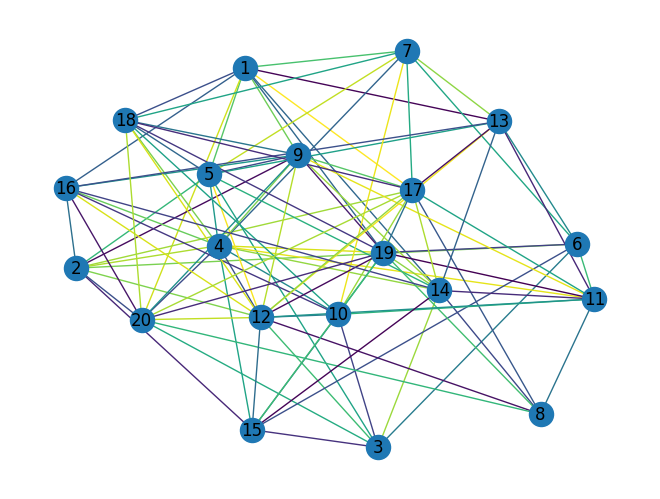

Time taken: 23.752272367477417 seconds

Running test graph_121_edges.txt...
[ 86  16  53 119   8  60  65 101   0 120   3  23  85  40   2  81  39   3
  39  50   4  16  68  48 103   2  58  11  83 111  46  87  36  30  19 118
   2   5 106  76   1  46  58  20  52  45   5 117   5  88   6  99  59  65
  17  78  89  20 104  35   5 103  27  60  16  46  81  81 116  56  99   3
  69  20  51 113  75 111 100  26  21  44  33 119   7   4  65  36  62  27
  88 101  61  95  84  86 107  28 102 113  29 110  34  84 104  46  57  48
 120  18  91 103 118  76  75  97 101 120  15 108  62]
Minimum edge coloring found.
Number of colors: 78
Number of iterations: 121


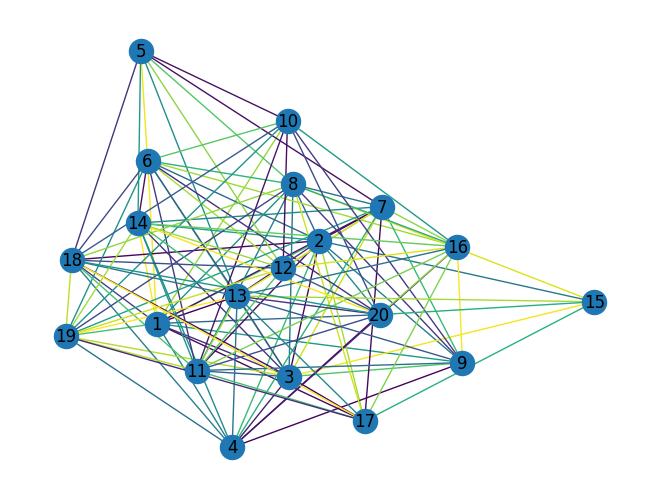

Time taken: 22.098594665527344 seconds

Running test graph_140_edges.txt...
[118  15 128 109  60 134  54  82  99  13  26  16 100 102 122 133  87   4
 116  80  26  76  28 115   8  56 100  61 128 113   8  28  15 137  22  72
  98  58  36  66 111  36  44  99 133 130  43  10   3  84  18  33 133  50
  32  11  46 134  17  74  83  98  27  97  31 117  40 139  12 134  64  76
  28  40 131   4  21 120  36  27  87  75  48 127  77 106 122 116  14 110
   4  45 118  92  67 133 129  18  33  29  51  77  67 101  25  28  44 124
 104 119  93 126 127  52 112  12  62  57  48  25  50  39  61  96 102  72
  47  47  45 107 110  88  92   3 103  68 104  47  68   8]
Minimum edge coloring found.
Number of colors: 92
Number of iterations: 140


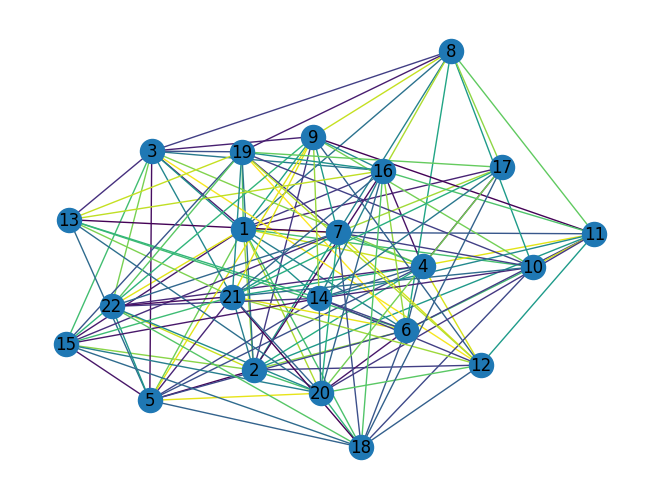

Time taken: 31.82273006439209 seconds

Running test graph_156_edges.txt...
[124  49 136  98 138  92 120 151  29  87 101  89   4   0  89  31  59 114
   8  98  50 108  26  81  65 131 136 129 121  37 115  99  73   6 149  25
  88 138 118   9 121  79 146 143  42 102 107 138  82 145 139  19  97  32
  92  64 120  86  43  53  34  93  55 151 129 140 155 141 147 145  21  39
  70 145  77  76  53 129 145  59  16   4 133  79  32  84   9 108   3 154
  68  36  54  39 149 146  26  94  41 108  90  58 122  28 123 120  25  77
  63  45 118 154 147   3  18 103  41  64  47 153  40 127  17 133  25  94
  64  34  28  77 132  76  28   2  21  71 135 153  48  58  80  61 114  11
  62 125  98  27 101 130 144  88 125  99  26 152]
Minimum edge coloring found.
Number of colors: 102
Number of iterations: 156


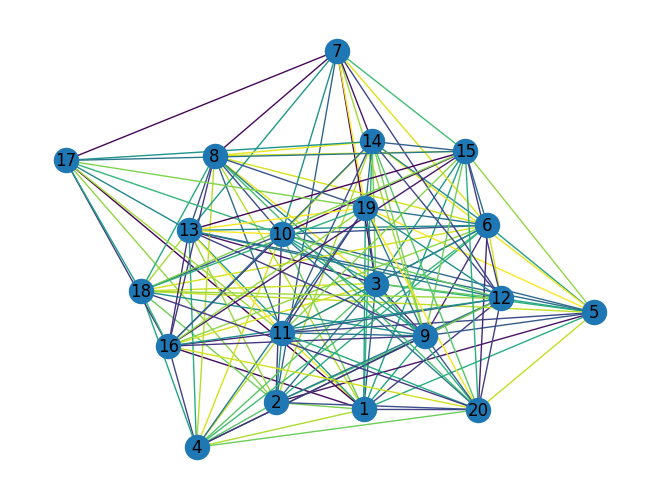

Time taken: 35.51994347572327 seconds

Running test graph_165_edges.txt...
[ 21  45  24  78 122  83  48 134  22  25 161  50 105   3  52 152  30  95
 133   3 103  73 119  97  15  96 127 139 117  44 151  10 108 158  91 127
  62 130 146   4  71 143  83 144 102 159  36 152 145 101  61 117 149 103
 125 127 101   8 102  40 110 123  23  53   8  88 141 164  43   2  77  48
 162  30 127 114 154 139 112  66  67  45 151 112 123 164  32 136  63  35
  52  40  79  11  29 109  34  17  42  17   4 148  97  10  62  87  46 124
  89 136  97  54  14  22  55   8  84 138  56 150  21 111  17  17 160 159
  58 135  42 163 101 133  68 161 151 121 146  64 106   0  41  66 154 149
 163  99  88  70  53 112  85 139 100  21 106 121  98  27  31  29 145  70
  21 156  13]
Minimum edge coloring found.
Number of colors: 110
Number of iterations: 165


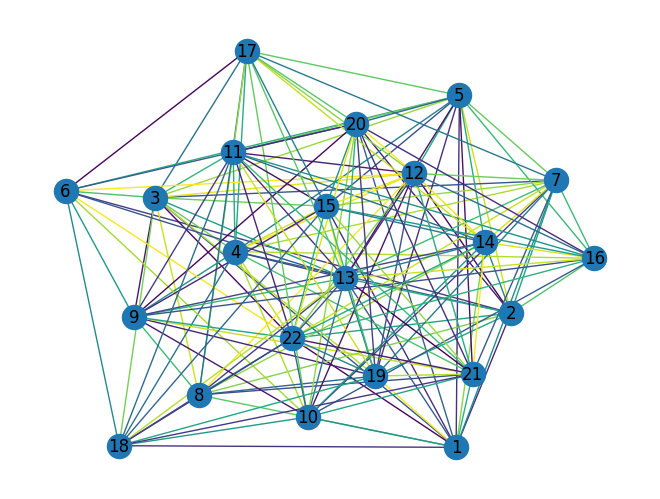

Time taken: 37.73646283149719 seconds

Running test graph_177_edges.txt...
[ 14 146  19  18  41  71 175  50 113  84  73  81  61   9 128 112  64  11
  67  65  87 121  61 104  71  65  98 175 153 117  92  53  34 149 133 116
 155 148  56  40  22  53 109 121  52   0 120 146 141 123  90  26 114  64
 131  16  18  82 123 118 126   8  37  32  32 137  71  49  90 113  97  41
  18  37 143  88  32 134 126 154  34 154  51  91  56  85  66  27  45  20
 110   5  71  82  93  28  37 133 111  75 136 149 160  59 145  91  84 171
  26  82  25 109 130  80 153  91  58  60  60 176 107 126 122 114 141  84
  85  10 101 155 116   1 134  51  10  79 102  71 171 140 160  13 172  42
  42  39 129  28 122  92 109  85   8 138 132  18  38  95  40 153  55 138
 159  68  96  70  22 131  56 173  56  61 103  58 104 151  59]
Minimum edge coloring found.
Number of colors: 110
Number of iterations: 177


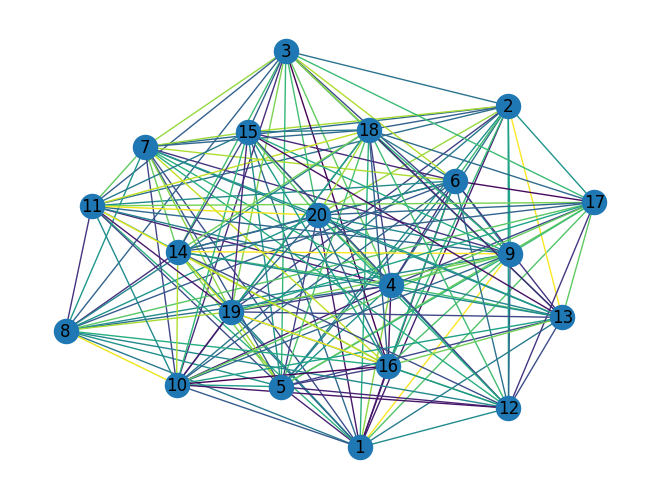

Time taken: 40.558852434158325 seconds

Running test graph_204_edges.txt...
[121  68 197  97  10 157  22 151 203  54 127   4   3  72  70  38   0 112
 186  63  19  64 165 199  82   4 104 107 123 101  35 114 179 149 164 175
  91 180  16 158 187 117 153  17  83  48 118  77 164 134 122  85 168  21
 139 152 114 102 130  15 142  41  84   5 106 123  83 134  44   5  13  35
  42  94  49  12  56  77 196  93  28 180 183  45  56 188  11 154 179  80
 160 146  73 116 178 101 104 169  31  68 197 161 119  73  64 130  60 192
 189 164  44 174  39 103  53  66  20  90 121   1 156 130 167  25 168 128
  96  18 179 184   7 155 182  38  85 119  63 147  61   5 173 163 142 125
   5   5 162  91  38 128 135  15   1  14 171 112  18 132 105 147  26 179
  27  52 146  46 167  99  83  13 148  34   3  26 127  51 165 164  17  75
  48 105 161 201 132  89 158  67 128 149 127  96   6 198 174 182  36 150
  85 112 202  94  69  45]
Minimum edge coloring found.
Number of colors: 137
Number of iterations: 204


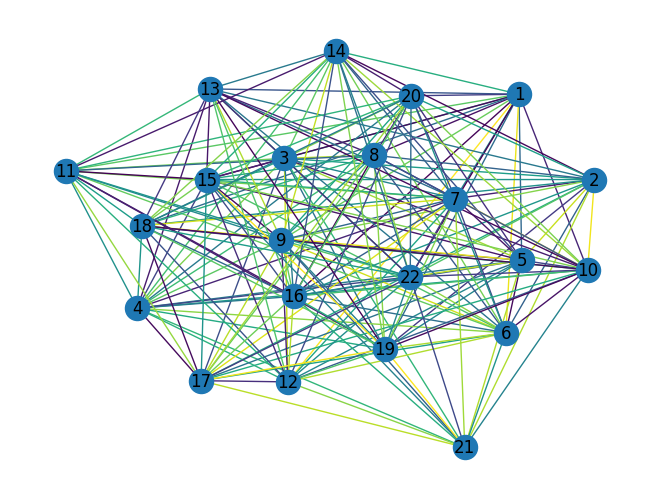

Time taken: 55.47770118713379 seconds

Running test graph_227_edges.txt...
[180  51  62 105 101 163 222  21  65 208 191  82  61  83  76 206  79  16
 112  88 226  46  64 109 195 216  41  90  21  72 193  54 215 178  83 189
  35  24   9 161  27 221  71  80  64 188  81  18  44  94 177 106  52 159
 108  70 206  15 168 136  18  54 133 155  72 142  94  34  72 111 168 123
  26 219 179 104 136  89 169  83 217  62  37 140  67 120 120   0  69 191
  93  76 148 125  91  41  22  82 181 193  61  30  34  39 154 106  15 219
  68   2 120 205 191  12  92  12  48 223   7  60  89 187 193  37 148  73
 123  83 145  65 137 123 218 131 183  34 204 171  20   5  62 193  67 206
 176 223  21 107 131 166  56 148  26 182 101  40 113 205 181  68  10   9
 167  81  46  95  29 122 135  45  67 148 179  88 223 210 144 111  96 143
  83 121   9  65 167  55  66 180 141 146  42   0  99 208 208 184 156   8
  33 144  22  81 181 180  27 218 215 148 129  63  43  39  40 150  36   0
 202 193 196 222 182 189 206 147 146 142 204]
Min

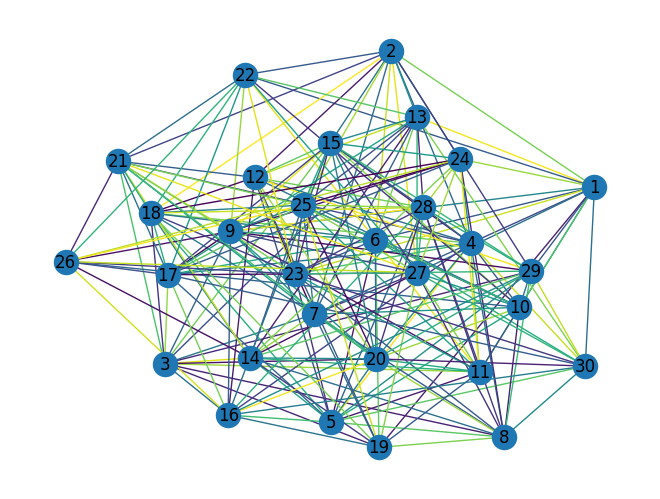

Time taken: 67.55903220176697 seconds

Running test graph_273_edges.txt...
[ 81  61  25  96 104 177  97 103 126  55 185 141 127 152 182  56 249 194
  20 117 110  42 243 102  45 210 254  50 267 190  97 114 195 150 203  23
 206 143 209  17  11 157  24 103 136 134 132 187 117 213 126 198 215 210
 232  18 206 195  96 201 144 197 141  96 166 188 249  16 133 252  53 235
   8 250 130 127 241  27  94  12  29  18 148 212 243  77 191 129   3   8
   7 186  17  90 189 186 102 174 233 232 105 239 208 138  54  33 181 194
  11 245 126 175 225  64 151  26 101 152 146 206 128  61 158  77  75 126
 234  32  98 224  63 202 205 230 234 100   6  54  96  81 148 252 208  18
   4 247 218  37  20 224 257 150  65 105 117  40 250 176 168 217  66 128
  48 225  45 104 271  24 215 225 237 205 215 203 140   6  98  71  75 121
  70 208 150  49 123 124  45 119 117  44  60 113  72  66 265 243 113  98
  64 102 114 117 236  11 106 181 224 210  14 113 232  74 125  49 232  91
  36 226 158 234 127  37 164 134 167 164 175 204 

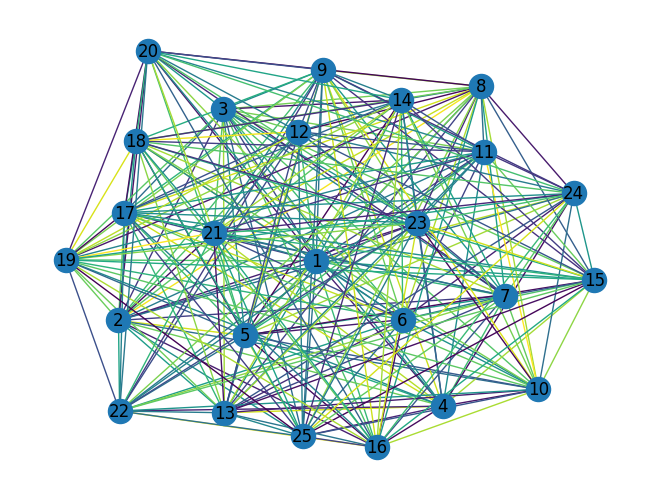

Time taken: 90.47071242332458 seconds

Running test graph_275_edges.txt...
[ 68 112 167 197   0 146 127 214 138 198  80 204 203  75  32 262 223  75
  55 233 188 263 146  45 258 249  90 226  99  95  15 201 105 183  43 220
 174  35 189 228 149 223 207 164 140  41 158 102 196 161 251 174 224  45
  10 133 184 155  11  16  45 203 139 108 229  39 241 218 188 192 183 235
 236  15 175 205  63  84 126 197 157 126  88 146 127  59 222 174 249 215
 140 188 196  39 208  41 210 208 121 195 114 228  73  84 183  20  24  56
  54 112  43 204 262 218 269  48   5 210  79 120  83  85 135 207  28 115
 110 273 265 217  54 138  37 180 246 110 107 158  40 169 205 229  29 111
 250  33 244  91 179 130  70 138  31  38  53 270 237   4 145  59 188 273
 263 261 146  76  28 202 255 220 226  42  85  87 125 176 194  29  39  14
  18 243 157 256 200  67 115  22 161 116 252  39  76 123 129 184  61  84
 226 172 190 224 185  52 260  58 171 120 193   7 250 170  96  68 219   4
 237  75 248 185   3  74 102  85  18  40 268 133 

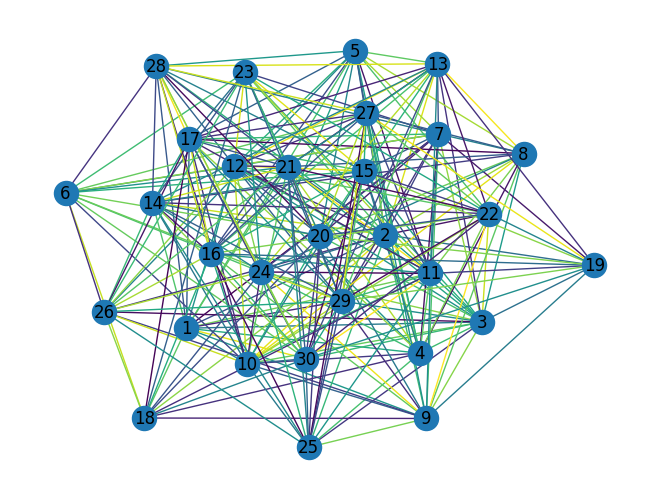

Time taken: 103.70428156852722 seconds



In [11]:
with open('./results/pso_results.txt', 'w') as result_file:
    result_file.write("")

run_tests('./tests')